We have a digital bank data and going to predict the expenses and income of the users in the future

In [1]:
#imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import TimeSeriesSplit


from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#helper to calculate rsmle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(np.exp(y), np.exp(y_pred)))


### data upload

In [7]:
df = pd.read_csv("training.csv")
transaction = pd.read_csv("transaction_types.csv")
mcc_group = pd.read_csv("mcc_group_definition.csv")

### data merging

In [8]:
mcc_group['explanation'] = mcc_group['explanation'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]','_', x).strip())

df2 = df.merge(mcc_group, on='mcc_group', how='left')
df2 = df2.merge(transaction, left_on='transaction_type', right_on='type', suffixes=('_card', '_transaction')).drop(['type','transaction_type', 'dataset_user', 'dataset_transaction' ], axis=1)
df2['transaction_date'] = pd.to_datetime(df2['transaction_date'])

## data Analysis

In [15]:
df2.describe()

,transaction_date,mcc_group,amount_n26_currency
count,408546,258324.000000,408546.000000
mean,2016-05-02 18:47:10.365246464,4.840166,52.764164
min,2016-02-01 00:00:00,1.000000,3.000000
25%,2016-03-19 00:00:00,1.000000,7.000000
50%,2016-05-03 00:00:00,3.000000,17.000000
75%,2016-06-17 00:00:00,7.000000,38.000000
max,2016-07-31 00:00:00,17.000000,1166.000000
std,NaN,4.574400,111.870681


looks like amount_n26_currency variable is skewed because std is quite high

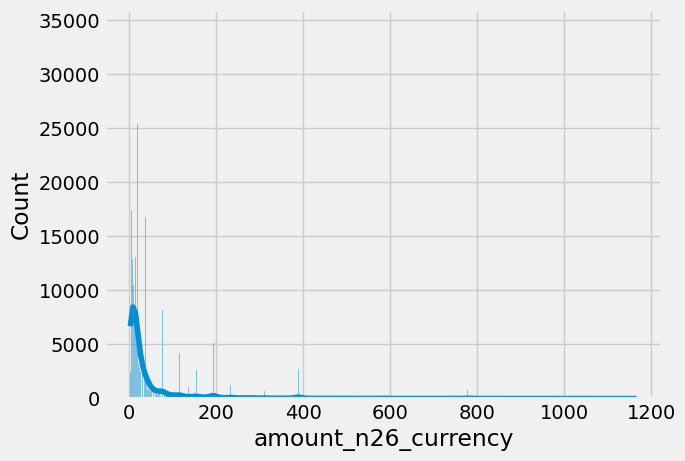

In [19]:
# Visualize the distribution of amount_n26_currency
sns.histplot(df2['amount_n26_currency'], kde=True)
plt.show()

In [9]:
def weekly_amount_trend(**kwargs):
    """
    Mean transaction amount on a weekly basis for a given feature
    """
    feature = kwargs.get('feature', None)
    f = df2.groupby([*feature, pd.Grouper(key='transaction_date',freq='W')])['amount_n26_currency'].mean().reset_index()
    f['transaction_date'] = f['transaction_date'].dt.date
    f.columns = [*feature,'transaction_date','mean']
    hue = feature[0]
    val = None if len(feature) == 1 else feature[1] 
    aspect = 1 if val is not None else 2
    height = 10 if val is not None else 7
    g = sns.catplot(x="transaction_date", 
            y = 'mean',
            hue = hue,
            col = val,
            data=f, 
            kind='point', 
            height = height,
            aspect = aspect,
            palette=sns.color_palette("bright", 9)
            )
    g.set_xticklabels(rotation=90)

/var/folders/yq/l2nbyft574135ccrtvzrsqq80000gp/T/ipykernel_7086/2287565861.py:13: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  g = sns.catplot(x="transaction_date",


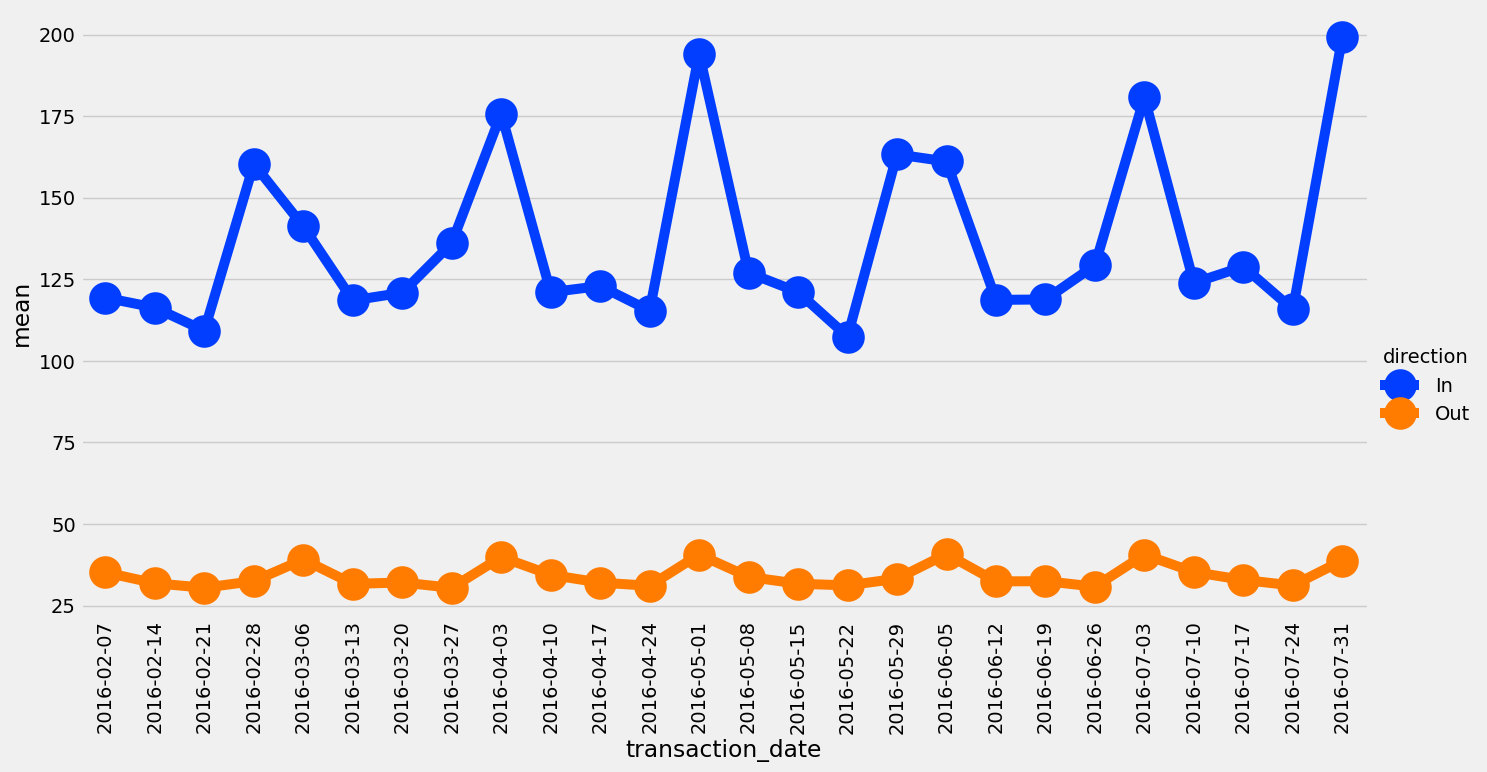

In [10]:
weekly_amount_trend(feature=['direction'])

at the end of each month (in last weeks) credit transfer of bigger amount than usual can be observed. possibly salary is credited to account.

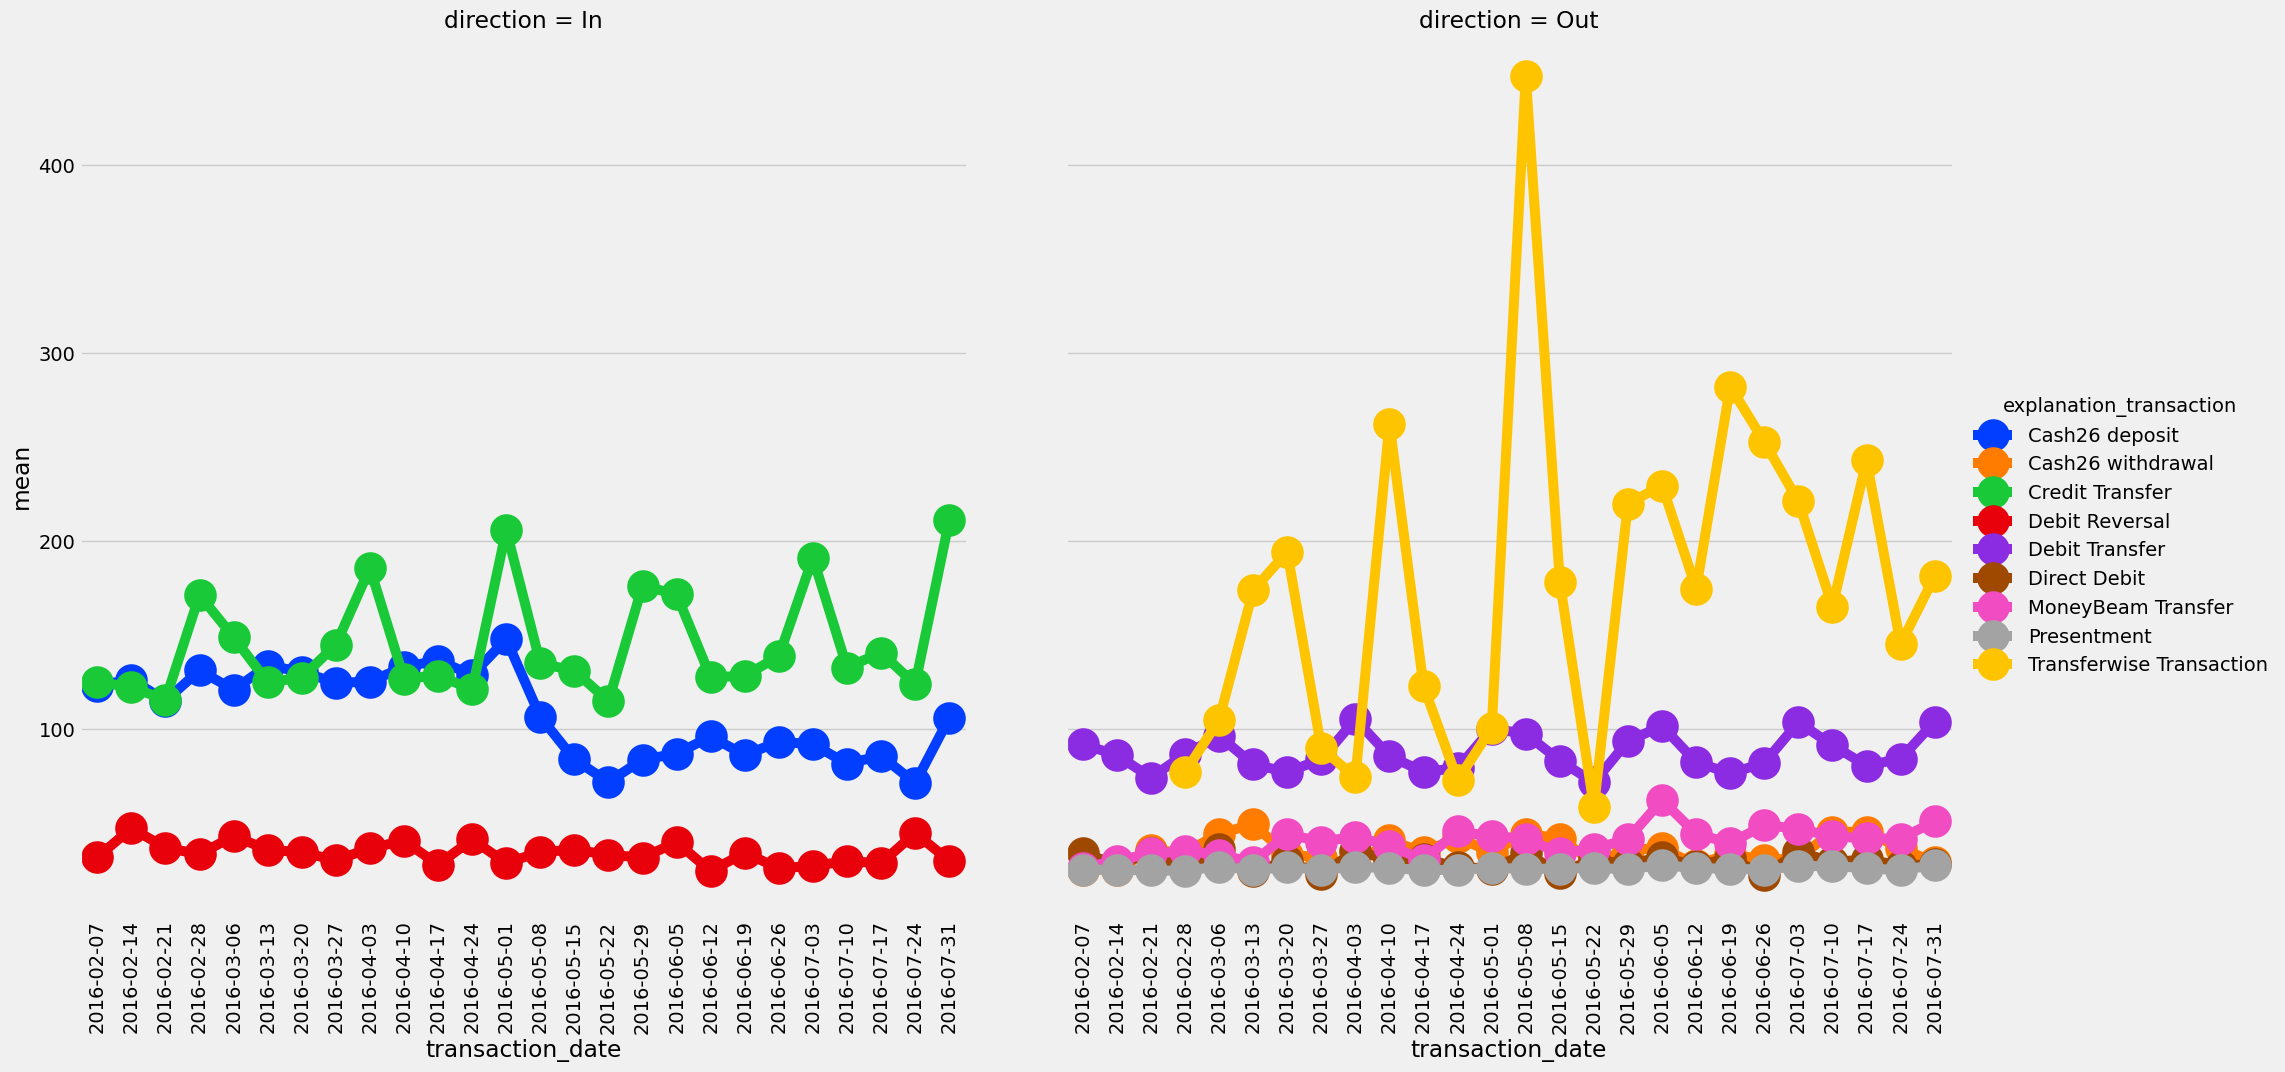

In [12]:
weekly_amount_trend(feature= ['explanation_transaction', 'direction'])

We see that the usage of transferwise is increasing over the weeks in expenses data. Users are using transferwise more for making debit transactions.

In [13]:
def weekly_popularity_trend(feature, **kwargs):
    """
    Feature popularity on weekly basis
    """
    f = df2.groupby([feature, pd.Grouper(key='transaction_date',freq='W')]).size().reset_index()
    f['transaction_date'] = f['transaction_date'].dt.date
    f.columns = [feature,'transaction_date','count']
    sns.catplot(x="transaction_date", 
            y = 'count',
            hue = feature, 
            data=f, 
            kind='point', 
            height=7, 
            aspect= 2,
            palette='Paired')
    _ = plt.xticks(rotation=90)

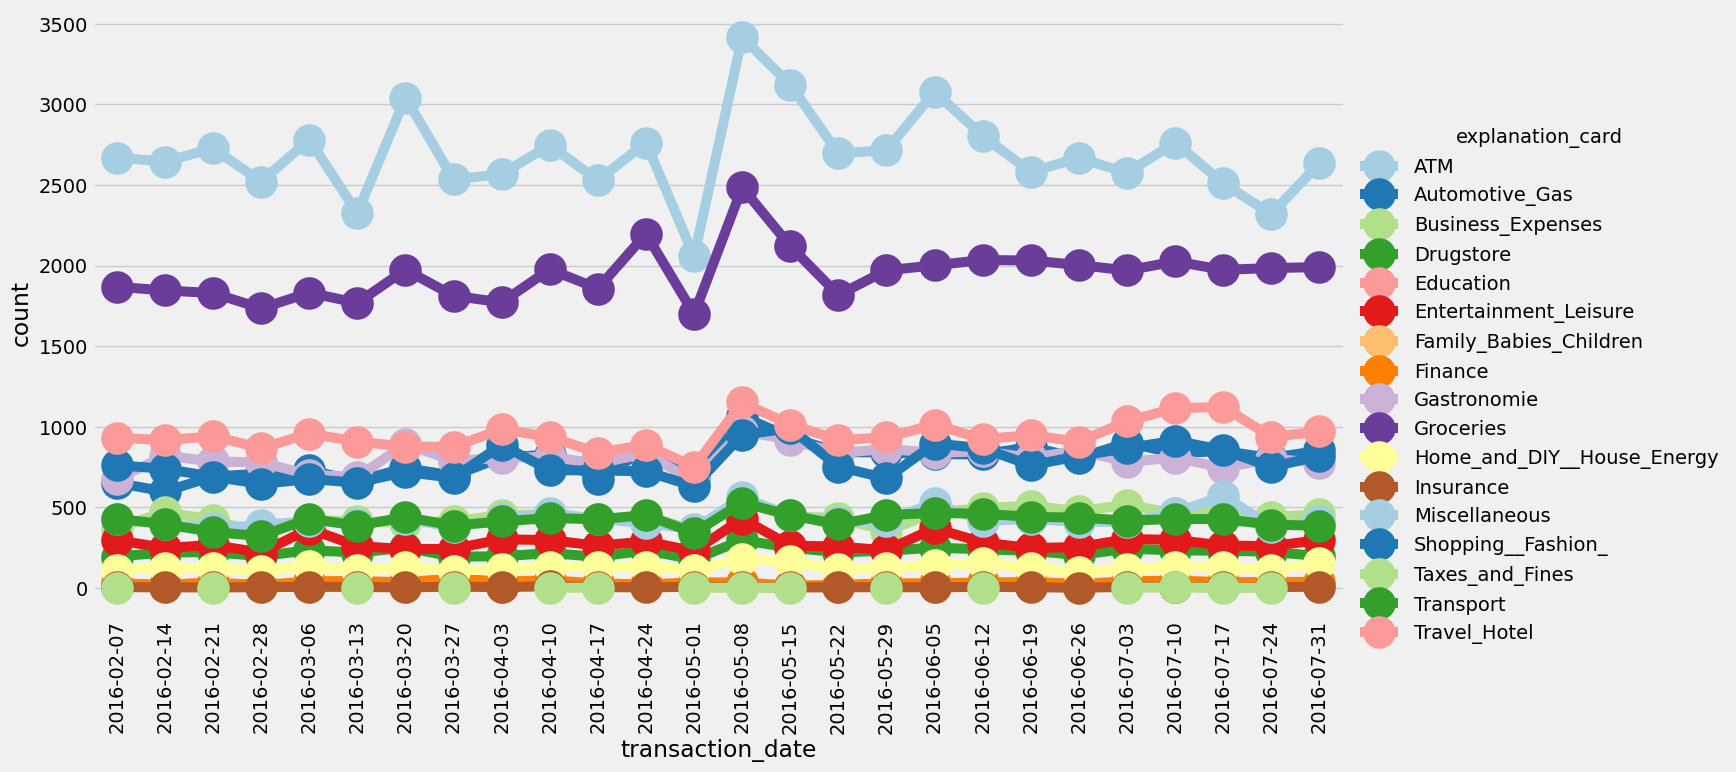

In [14]:
weekly_popularity_trend('explanation_card')

We can see that ATM has the highest weekly usage. Also, there is a peak in the last week of May that can be observed across all explanation_card. 
Meaning that either these transtion peaked due to summer holidays or some marketing campaign happened.

In [18]:
#creating 2 datasets, one for income (in), and other for the expenses (out)

df_in = df2.query("direction == 'In'").drop(['direction','explanation_card','mcc_group','explanation_transaction','agent'], axis=1)
df_out = df2.query("direction == 'Out'").drop(['direction','explanation_card','mcc_group','explanation_transaction','agent'], axis=1)

In [22]:
df_in.sort_values(by='transaction_date', inplace=True)
df_out.sort_values(by='transaction_date', inplace=True)


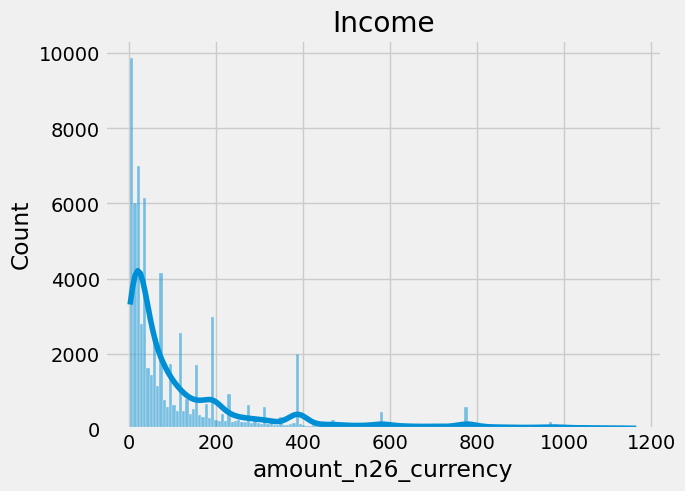

In [23]:
#visualising distrb. in both income and expenses dataframes separately

sns.histplot(df_in['amount_n26_currency'], kde=True)
plt.title('Income')
plt.show()

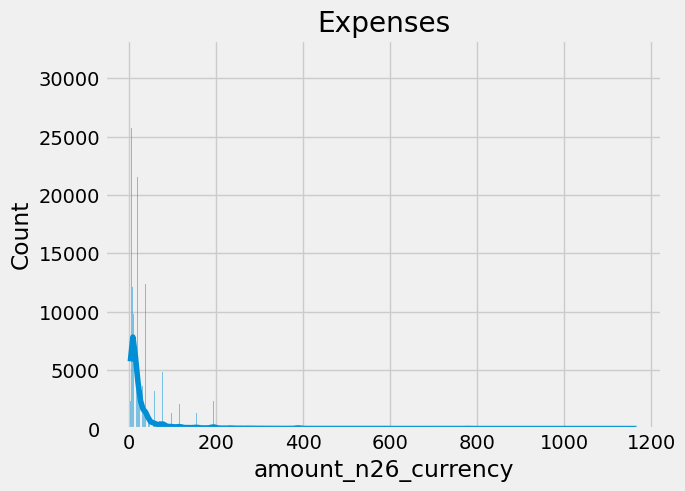

In [24]:
sns.histplot(df_out['amount_n26_currency'], kde=True)
plt.title('Expenses')
plt.show()

In [10]:
#normalizing amount_n26_currency feature
df_in['log_income'] = np.log1p(df_in['amount_n26_currency'])

In [208]:
df_in.set_index('transaction_date', inplace = True)

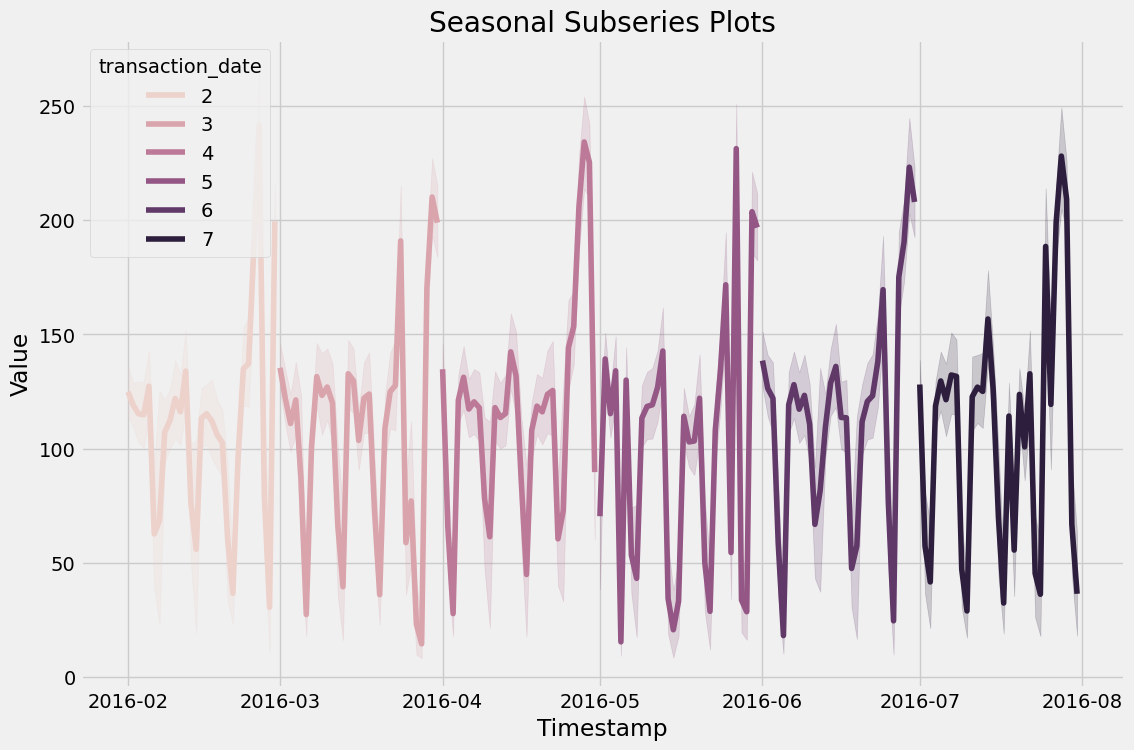

In [39]:
#income data seasonal plot

plt.figure(figsize=(12, 8))
sns.lineplot(x='transaction_date', y='amount_n26_currency', hue=df_in['transaction_date'].dt.month, data=df_in)
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Seasonal Subseries Plots')
plt.show()


We can see that near the end of each month there is big amount that is credited(salary), this trend can be noticed in all months

### features functions

In [40]:
# helpers to generate features in the training pipeline

In [41]:
class SeasonalTrend(BaseEstimator, TransformerMixin):

    """
    Create seasonal trend and lag features in the pipeline.
    """
    def fit(self, X, y=None):
        return self
    

    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):

            col = 'log_income'
            weeks_in_month = 1
            # Apply seasonal decomposition to the current column
            decomp = seasonal_decompose(X[col], period=7, model='additive', extrapolate_trend='freq')
            # Create new columns in the DataFrame for trend and seasonal components
            X[f"{col}_trend"] = decomp.trend
            X[f"{col}_seasonal"] = decomp.seasonal

            #adding seasonal lags
            
            X[f"{col}_sesn1"] = X[col].shift(-1* weeks_in_month)
            X[f"{col}_sesn2"] = X[col].shift(-2* weeks_in_month)
            X[f"{col}_sesn3"] = X[col].shift(1* weeks_in_month)
            X[f"{col}_sesn4"] = X[col].shift(2* weeks_in_month)
            X[f"{col}_sesn5"] = X[col].shift(3* weeks_in_month)
            
            self.names = X[[x for x in X.columns if 'log_income_' in x]].columns.tolist()
            return X[[x for x in X.columns if 'log_income_' in x]]
        
        else:
            raise Exception("Only supported for pd.DataFrame")
    
    def get_features_names(self):
        return self.names

In [13]:
df_in.head(2)

,user_id,transaction_date,amount_n26_currency,log_income
40528,77a52d4da43d0106d321cdc1364bfe01,2016-02-01,24,3.218876
41067,a26d8269caddf886b3d3f51205116a46,2016-02-01,38,3.663562


In [12]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):

    """
    Create frequency card and transaction features in the pipeline.
    """
    def fit(self, X, y=None):
        return self
    

    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):

            # Compute and store the frequency information during fit
            explanation_card_freq_ = X['explanation_card'].value_counts(normalize=True)
            explanation_transaction_freq_ = X['explanation_transaction'].value_counts(normalize=True)
            
            # Map the computed frequencies to create new features
            X['explanation_card_frequency'] = X['explanation_card'].map(explanation_card_freq_)
            X['explanation_transaction_frequency'] = X['explanation_transaction'].map(explanation_transaction_freq_)
    
            self.names = X[[x for x in X.columns if '_frequency' in x]].columns.tolist()
            return X[[x for x in X.columns if '_frequency' in x]]
        
        else:
            raise Exception("Only supported for pd.DataFrame")
    
    def get_features_names(self):
        return self.names


In [42]:

class DateEncoder(TransformerMixin, BaseEstimator):
    
    """
    Create date features in the pipeline.
    """
    
    def fit(self, X, y=None):
        return self
    

    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            
            col = 'transaction_date'
            X[f"{col}_weekday"] = X[col].dt.dayofweek
            X[f"{col}_weekofyear"] = X[col].dt.isocalendar().week
            X[f"{col}_dayofmonth"] = X[col].dt.day
            X[f"{col}_quarter"] = X[col].dt.quarter
            X[f"{col}_month"] = X[col].dt.month
            X[f"{col}_dayofyear"] = X[col].dt.dayofyear
            
            self.names = X[[x for x in X.columns if 'transaction_date' in x]].columns.tolist()
            return X[[x for x in X.columns if 'transaction_date' in x]]
        else:
            raise Exception("Only supported for pd.DataFrame")
    
    def get_features_names(self):
        return self.names
    

In [43]:
class MakeLagFeatures(TransformerMixin, BaseEstimator):
    
    """
    Creat aggregate lag features in the pipeline
    """
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            
            lags = [1,3,7]
            for lag in lags:
                # lag feature
                X[f'income_lag_mean_{lag}'] = X.groupby(['user_id'])['log_income'].shift(lag)
                # rolling average
                X[f'income_lag_rolling_mean_{lag}'] = X.groupby(['user_id'])['log_income'].shift(lag).rolling(2).mean()
                # cumulative average
                X[f'income_lag_expand_mean_{lag}'] = X.groupby(['user_id'])['log_income'].shift(lag).expanding().mean()
                
            self.names = X[[x for x in X.columns if 'income' in x]].columns.tolist()
            return X[[x for x in X.columns if 'income' in x]].values
        else:
            raise Exception("Only supported for pd.DataFrame")
    
    def get_features_names(self):
        return self.names

In [44]:
def generate_pipeline():
    
    features = ColumnTransformer(
        [('date_features',DateEncoder(), ['transaction_date']), 
         #('frequency_encoding', FrequencyEncoder(), ['explanation_card', 'explanation_transaction']),
         ('lag_features', MakeLagFeatures(), ['user_id','log_income']),
         ('sesntrend_features', SeasonalTrend(), ['log_income'])
        ],  
        remainder= 'drop',
        sparse_threshold=0.3,
        n_jobs=None,
        transformer_weights=None
    )
    feats_pipeline = Pipeline([
        ('features', features),
    ]) 
    return feats_pipeline


## Income model


In [21]:
#train test split

#feb-july
train_a = df_in.loc[df_in.transaction_date <='30-06-2016']

#August
test_a = df_in.loc[df_in.transaction_date > '30-06-2016']

In [46]:
feats_pipeline = generate_pipeline()

# Fit and transform the training data
train_transformed = feats_pipeline.fit_transform(train_a)

#get all the features names
feature_names = (feats_pipeline.named_steps['features'].named_transformers_['date_features'].get_features_names() + 
                #feats_pipeline.named_steps['features'].named_transformers_['frequency_encoding'].get_features_names()+ 
                feats_pipeline.named_steps['features'].named_transformers_['lag_features'].get_features_names()+
                feats_pipeline.named_steps['features'].named_transformers_['sesntrend_features'].get_features_names())

# Creating a DataFrame with the transformed data and feature names
train_df = pd.DataFrame(train_transformed, columns=feature_names,)


In [47]:
def convert_columns_to_dtype(df):
    """
    Convert specified columns to the desired data types (int or float).

    """
    int_cols = ['transaction_date_weekday',
     'transaction_date_weekofyear',
     'transaction_date_dayofmonth',
     'transaction_date_quarter',
     'transaction_date_month',
     'transaction_date_dayofyear',]
    
    float_cols = [
     'log_income',
     'income_lag_mean_1',
     'income_lag_rolling_mean_1',
     'income_lag_expand_mean_1',
     'income_lag_mean_3',
     'income_lag_rolling_mean_3',
     'income_lag_expand_mean_3',
     'income_lag_mean_7',
     'income_lag_rolling_mean_7',
     'income_lag_expand_mean_7',
     'log_income_trend',
     'log_income_seasonal',
     'log_income_sesn1',
     'log_income_sesn2',
     'log_income_sesn3',
     'log_income_sesn4',
     'log_income_sesn5' ]
    
    df[int_cols] = df[int_cols].astype(int)
    df[float_cols] = df[float_cols].astype(float)
    df['transaction_date'] = df['transaction_date'].astype('datetime64[ns]')
    df.set_index('transaction_date', inplace = True)
        
    return df

In [48]:
train_df = convert_columns_to_dtype(train_df)

### cross validation

Using RMSLE as our performance metric because:

It doesn't penalises differences in large numbers as compared to RMSE which would inflate the error due to large difference in predictions among higher numbers.
The target variable is skewed, we would like a metric which can help us estimate the model performance on overall data rather than weighing the cases differently.

In [49]:
tss = TimeSeriesSplit(n_splits=5)

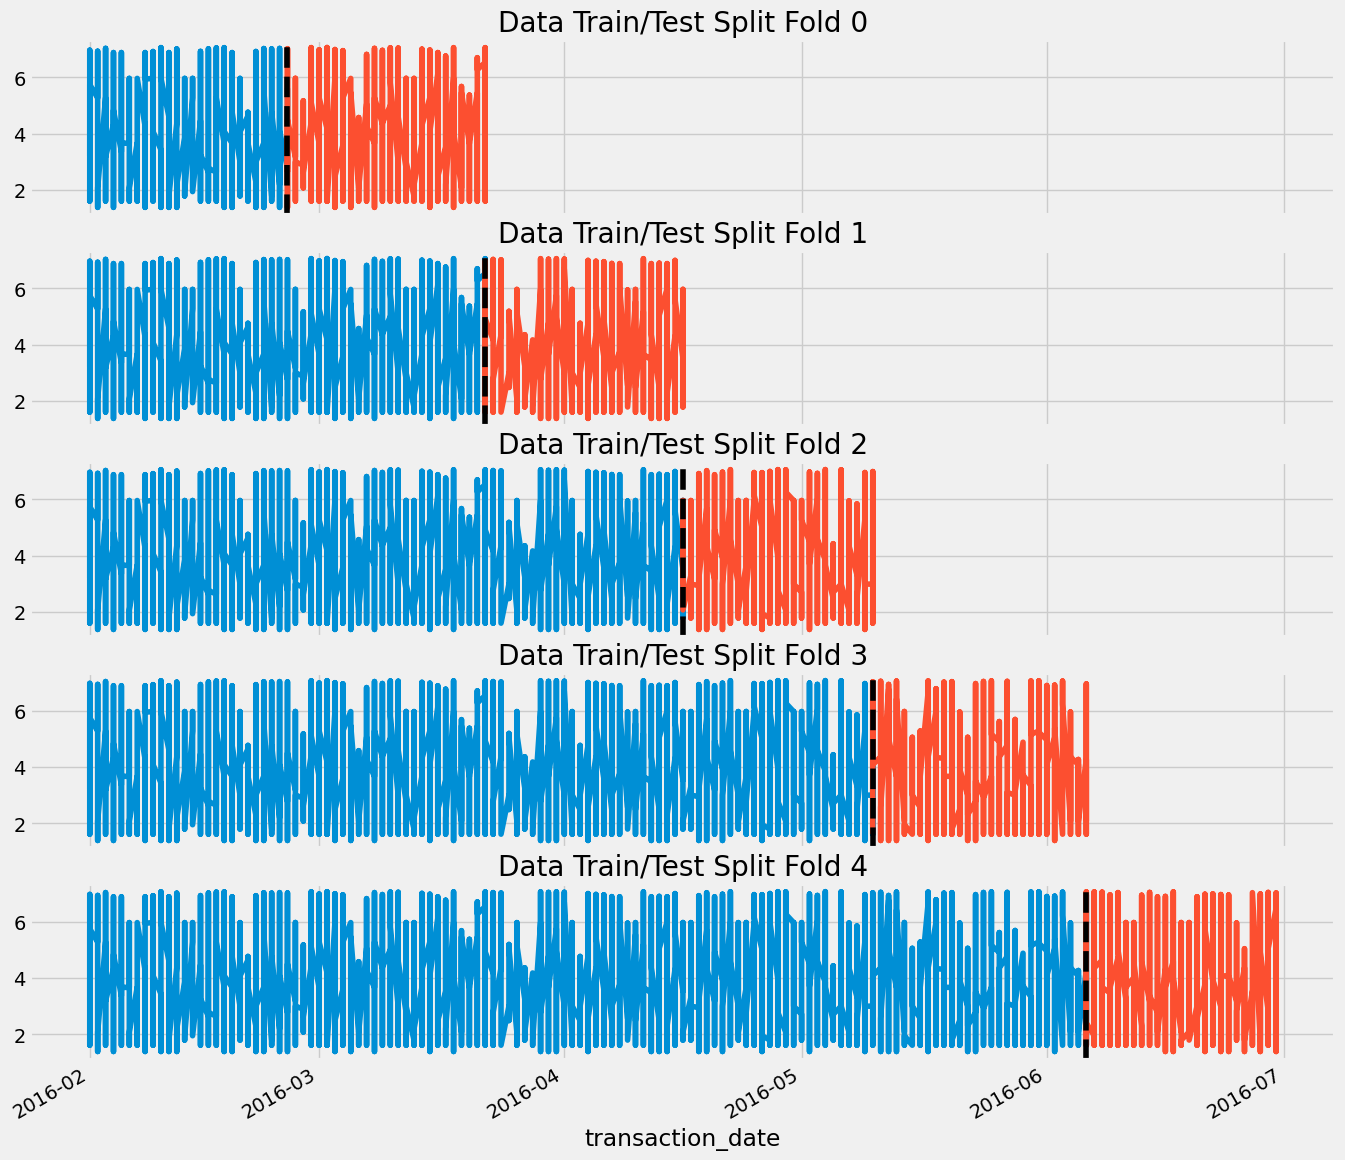

In [68]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(train_df):
    train = train_df.iloc[train_idx]
    test = train_df.iloc[val_idx]
    train['log_income'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['log_income'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()


In [69]:
FEATURES = [ 'transaction_date_weekday', 'transaction_date_dayofmonth','transaction_date_month',
 'transaction_date_dayofyear','income_lag_mean_1','income_lag_rolling_mean_1','income_lag_expand_mean_1',
 'income_lag_mean_3','income_lag_rolling_mean_3','income_lag_expand_mean_3','income_lag_mean_7',
 'income_lag_rolling_mean_7','income_lag_expand_mean_7','log_income_trend','log_income_seasonal',
 'log_income_sesn1','log_income_sesn2','log_income_sesn3','log_income_sesn4','log_income_sesn5' ]

TARGET = 'log_income'

In [70]:
#performing cross validation only with train data
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(train_df):
    train1 = train_df.iloc[train_idx]
    test1 = train_df.iloc[val_idx]

    X_train = train1[FEATURES]
    y_train = train1[TARGET]

    X_test = test1[FEATURES]
    y_test = test1[TARGET]

    clf = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           base_score=0.5,
                           max_depth= 3,
                           learning_rate=0.06,
                           eval_metric='rmsle',
                          )
    clf.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = clf.predict(X_test)
    preds.append(y_pred)
    
    score = rmsle(y_test, y_pred)
    scores.append(score)



[0]	validation_0-rmsle:1.06387	validation_1-rmsle:1.08698
[100]	validation_0-rmsle:0.21110	validation_1-rmsle:0.21347
[200]	validation_0-rmsle:0.19401	validation_1-rmsle:0.20205
[300]	validation_0-rmsle:0.18439	validation_1-rmsle:0.19731
[400]	validation_0-rmsle:0.17846	validation_1-rmsle:0.19514
[500]	validation_0-rmsle:0.17444	validation_1-rmsle:0.19414
[559]	validation_0-rmsle:0.17260	validation_1-rmsle:0.19454
[0]	validation_0-rmsle:1.07369	validation_1-rmsle:1.09149
[100]	validation_0-rmsle:0.21280	validation_1-rmsle:0.21511
[200]	validation_0-rmsle:0.19707	validation_1-rmsle:0.20150
[300]	validation_0-rmsle:0.18831	validation_1-rmsle:0.19481
[400]	validation_0-rmsle:0.18316	validation_1-rmsle:0.19155
[500]	validation_0-rmsle:0.17981	validation_1-rmsle:0.18992
[600]	validation_0-rmsle:0.17746	validation_1-rmsle:0.18887
[686]	validation_0-rmsle:0.17587	validation_1-rmsle:0.18880
[0]	validation_0-rmsle:1.07895	validation_1-rmsle:1.09144
[100]	validation_0-rmsle:0.21371	validation_1-

In [60]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}') 

Score across folds 0.8728
Fold scores:[0.8992566233248052, 0.880939193408011, 0.8521730198403084, 0.8572020132363957, 0.8745452041196085]


### training model

In [64]:
X_train = train_df[FEATURES]
y_train = train_df[TARGET]


reg_in = xgb.XGBRegressor(booster='gbtree', 
                           n_estimators=750,
                           early_stopping_rounds=50,
                           base_score=0.5,
                           max_depth= 3,
                           learning_rate=0.06,
                           eval_metric='rmsle',
                      )
reg_in.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        verbose=100)

[0]	validation_0-rmsle:1.08260
[100]	validation_0-rmsle:0.21459
[200]	validation_0-rmsle:0.19958
[300]	validation_0-rmsle:0.19146
[400]	validation_0-rmsle:0.18678
[500]	validation_0-rmsle:0.18390
[600]	validation_0-rmsle:0.18196
[700]	validation_0-rmsle:0.18061
[749]	validation_0-rmsle:0.18007


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=750, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### preparing test data

In [71]:
# Fit and transform the training data
test_transformed = feats_pipeline.fit_transform(test_a)

test_df = pd.DataFrame(test_transformed, columns=feature_names,)
test_df = convert_columns_to_dtype(test_df)

### predictions on test

In [72]:
X_test = test_df[FEATURES]
y_test = test_df[TARGET]

In [73]:
X_test['pred'] = reg_in.predict(X_test)

/var/folders/yq/l2nbyft574135ccrtvzrsqq80000gp/T/ipykernel_6050/3304264586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pred'] = clf.predict(X_test)


In [74]:
rmsle(test_a['log_income'], X_test['pred'])

0.9008235501640228

### baseline vs xgb

In [75]:
baseline_model_predictions = [test_a['amount_n26_currency'].mean()]* test_df.shape[0]
rmsle_ = np.sqrt(mean_squared_log_error(test_a['amount_n26_currency'], baseline_model_predictions))
print(f"baseline model rmsle score: {rmsle_}")

baseline model rmsle score: 1.6219991073042273


In [76]:
rmsle_score = rmsle(test_df['log_income'],  X_test['pred'])
print(f"rmsle score: {rmsle_score}")

rmsle score: 0.9008235501640228


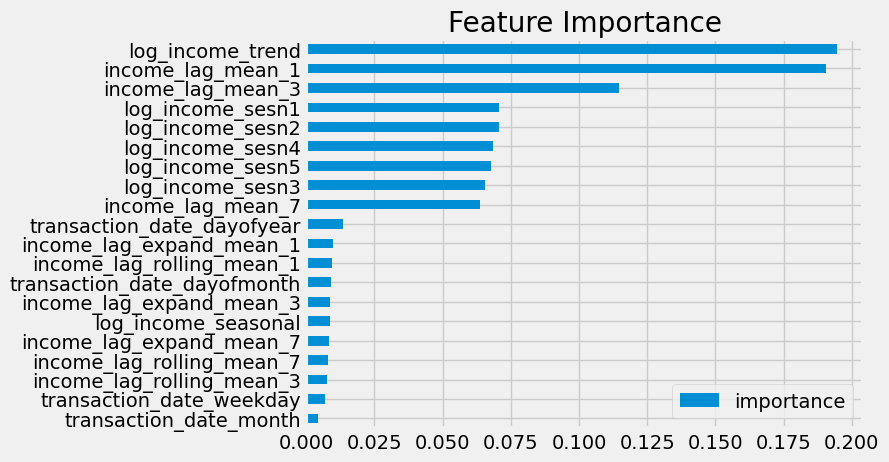

In [77]:
fi = pd.DataFrame(data=reg_in.feature_importances_,
             index=reg_in.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [78]:
#based on fi, dropping quarter and weekofyear

In [80]:
#chnaging values back to normal for visualization
test_df['log_income2'] = np.expm1(test_df['log_income'])
X_test['pred2'] = np.expm1(X_test['pred'])

/var/folders/yq/l2nbyft574135ccrtvzrsqq80000gp/T/ipykernel_6050/2293351327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pred2'] = np.expm1(X_test['pred'])


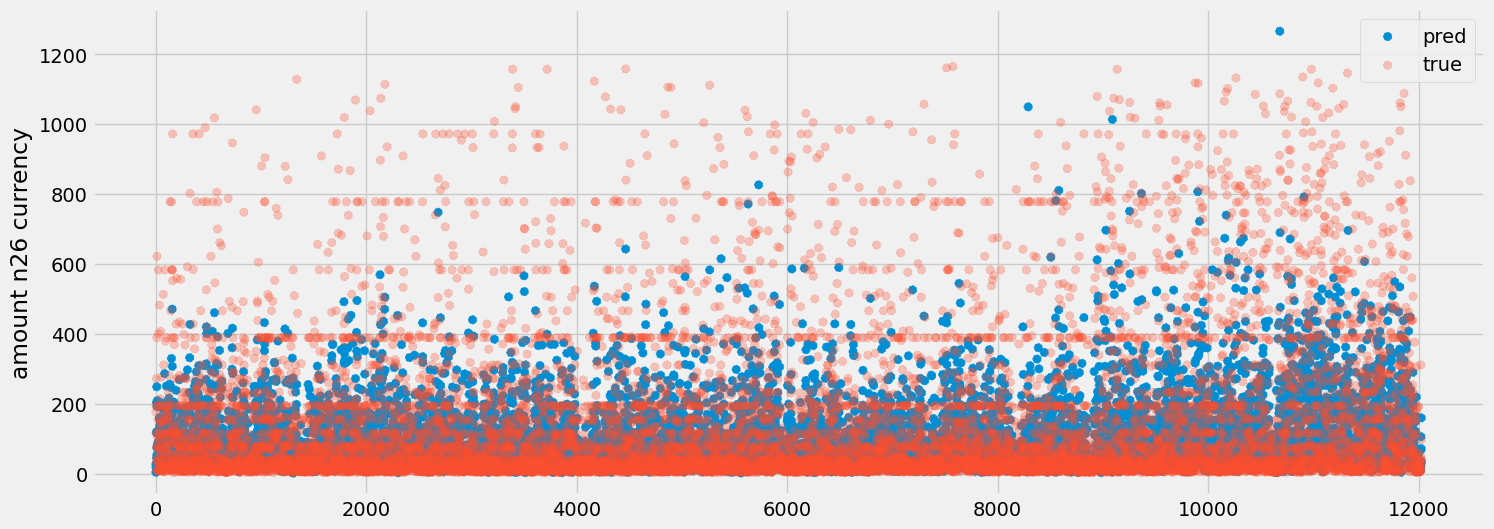

In [81]:
predictions = pd.DataFrame({'y_true': test_df['log_income2'], 'y_pred': X_test['pred2']})

plt.figure(figsize=(16,6))
plt.scatter(range(predictions.shape[0]), predictions['y_pred'], label='pred', linestyle='dashed',)
plt.scatter(range(predictions.shape[0]), predictions['y_true'], label='true', linestyle='dashed',alpha=0.3)
plt.ylabel('amount n26 currency')
plt.legend();

In [84]:
df_in.set_index('transaction_date', inplace = True)

In [87]:
df_new = df_in.merge(X_test[['pred2']], how='left', left_index=True, right_index=True)

/Users/kiran_akram/Desktop/kiran/ds_task/dsenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


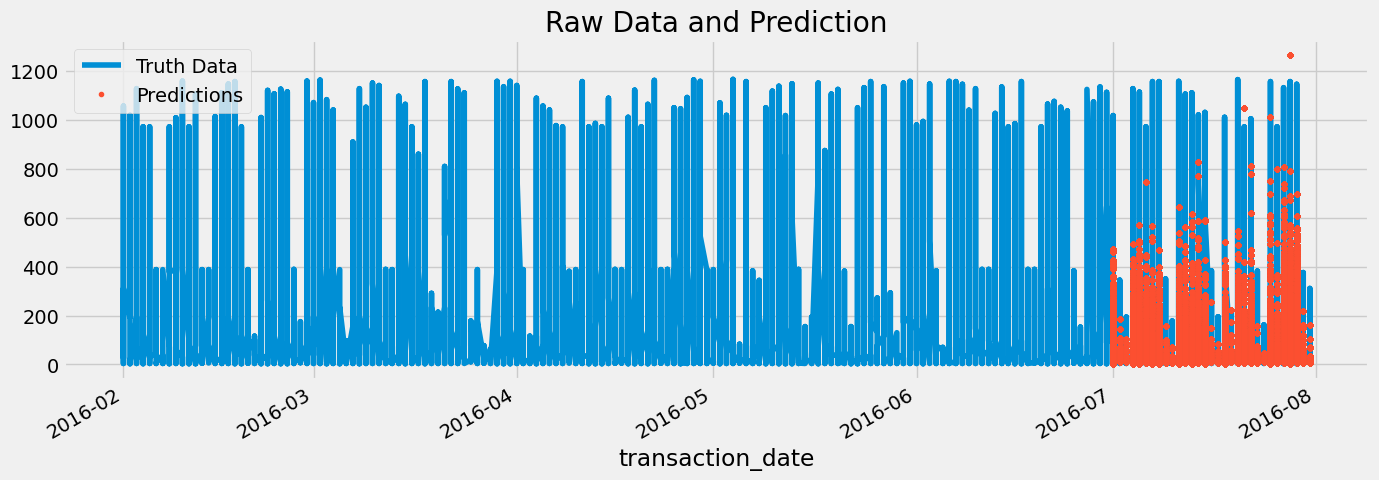

In [89]:
ax = df_new[['amount_n26_currency']].plot(figsize=(15, 5))
df_new['pred2'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

### Training on all the data:

In [90]:
def data_transformation(df):
    df_transformed = feats_pipeline.fit_transform(df)

    df_ = pd.DataFrame(df_transformed, columns=feature_names,)
    df_ = convert_columns_to_dtype(df_)

    return df_

In [92]:
df_in.reset_index(inplace = True)

In [93]:
income_data = data_transformation(df_in)

In [95]:
# Retrain on all data

X_all = income_data[FEATURES]
y_all = income_data[TARGET]

model = xgb.XGBRegressor(booster='gbtree', 
                           n_estimators=750,
                           early_stopping_rounds=50,
                           base_score=0.5,
                           max_depth= 3,
                           learning_rate=0.06,
                           eval_metric='rmsle',
                      )
model.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmsle:1.08326
[100]	validation_0-rmsle:0.21522
[200]	validation_0-rmsle:0.20020
[300]	validation_0-rmsle:0.19220
[400]	validation_0-rmsle:0.18760
[500]	validation_0-rmsle:0.18473
[600]	validation_0-rmsle:0.18282
[700]	validation_0-rmsle:0.18147
[749]	validation_0-rmsle:0.18093


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=750, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
#Saving model for later using pickle

#with open('income_pred_model.pkl', 'wb') as file:
    #pickle.dump(model, file)

# Load the model from the file
#with open('income_pred_model.pkl', 'rb') as file:
    #income_model = pickle.load(file)


## Expenses model


In [101]:
#normalizing amount_n26_currency feature
df_out['log_income'] = np.log1p(df_out['amount_n26_currency'])

In [102]:
#train test split
train_out = df_out.loc[df_out.transaction_date <='30-06-2016']
test_out = df_out.loc[df_out.transaction_date > '30-06-2016']

In [103]:
# Fit and transform the training data
train_out_transformed = feats_pipeline.fit_transform(train_out)

# Create a DataFrame with the transformed data and feature names
train_out_df = pd.DataFrame(train_out_transformed, columns=feature_names,)

train_out_df = convert_columns_to_dtype(train_out_df)

### cross validation

In [136]:
FEATURES = [ 'transaction_date_weekday', 'transaction_date_dayofmonth','transaction_date_month', 'transaction_date_weekofyear',
 'transaction_date_dayofyear','income_lag_mean_1','income_lag_rolling_mean_1','income_lag_expand_mean_1',
 'income_lag_mean_3','income_lag_rolling_mean_3','income_lag_expand_mean_3','income_lag_mean_7',
 'income_lag_rolling_mean_7','income_lag_expand_mean_7','log_income_trend','log_income_seasonal',
 'log_income_sesn1','log_income_sesn2','log_income_sesn3','log_income_sesn4','log_income_sesn5' ]

TARGET = 'log_income'

In [110]:
#performing cross validation only with train data
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(train_out_df):
    train1 = train_out_df.iloc[train_idx]
    test1 = train_out_df.iloc[val_idx]

    X_train = train1[FEATURES]
    y_train = train1[TARGET]

    X_test = test1[FEATURES]
    y_test = test1[TARGET]

    clf = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           base_score=0.5,
                           max_depth= 5,
                           learning_rate=0.06,
                           eval_metric='rmsle',
                          )
    clf.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = clf.predict(X_test)
    preds.append(y_pred)
    
    score = rmsle(y_test, y_pred)
    scores.append(score)



[0]	validation_0-rmsle:0.85382	validation_1-rmsle:0.85891
[100]	validation_0-rmsle:0.16789	validation_1-rmsle:0.17564
[200]	validation_0-rmsle:0.15535	validation_1-rmsle:0.16699
[300]	validation_0-rmsle:0.15021	validation_1-rmsle:0.16473
[400]	validation_0-rmsle:0.14712	validation_1-rmsle:0.16418
[500]	validation_0-rmsle:0.14477	validation_1-rmsle:0.16409
[518]	validation_0-rmsle:0.14435	validation_1-rmsle:0.16419
[0]	validation_0-rmsle:0.85616	validation_1-rmsle:0.86044
[100]	validation_0-rmsle:0.17095	validation_1-rmsle:0.17635
[200]	validation_0-rmsle:0.15938	validation_1-rmsle:0.16692
[300]	validation_0-rmsle:0.15506	validation_1-rmsle:0.16417
[400]	validation_0-rmsle:0.15275	validation_1-rmsle:0.16333
[500]	validation_0-rmsle:0.15109	validation_1-rmsle:0.16301
[600]	validation_0-rmsle:0.14970	validation_1-rmsle:0.16303
[606]	validation_0-rmsle:0.14963	validation_1-rmsle:0.16304
[0]	validation_0-rmsle:0.85754	validation_1-rmsle:0.85833
[100]	validation_0-rmsle:0.17246	validation_1-

In [115]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}') 

Score across folds 0.6345
Fold scores:[0.6333492678706383, 0.6309549983562951, 0.6409257593307984, 0.6397205813361014, 0.6276162511915264]


### training model

In [126]:
X_train = train_df[FEATURES]
y_train = train_df[TARGET]


reg = xgb.XGBRegressor(booster='gbtree', 
                           n_estimators=600,
                           early_stopping_rounds=50,
                           base_score=0.5,
                           max_depth= 5,
                           learning_rate=0.06,
                           eval_metric='rmsle',
                      )
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        verbose=100)

[0]	validation_0-rmsle:1.08212
[100]	validation_0-rmsle:0.19482
[200]	validation_0-rmsle:0.18049
[300]	validation_0-rmsle:0.17467
[400]	validation_0-rmsle:0.17126
[500]	validation_0-rmsle:0.16873
[599]	validation_0-rmsle:0.16668


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### preparing test data

In [117]:
# Fit and transform the training data
test_out_transformed = feats_pipeline.fit_transform(test_out)

test_out_df = pd.DataFrame(test_out_transformed, columns=feature_names,)
test_out_df = convert_columns_to_dtype(test_out_df)

### predictions on test

In [128]:
X_test_out = test_out_df[FEATURES]
y_test_out = test_out_df[TARGET]

In [129]:
X_test_out['pred'] = reg.predict(X_test_out)

In [130]:
rmsle(test_out_df['log_income'], X_test_out['pred'])

0.7316374101587142

### baseline vs xgb

In [123]:
baseline_model_predictions = [test_out['amount_n26_currency'].mean()]* test_out.shape[0]
rmsle_ = np.sqrt(mean_squared_log_error(test_out['amount_n26_currency'], baseline_model_predictions))
print(f"baseline model rmsle score: {rmsle_}")

baseline model rmsle score: 1.2434768770694895


In [124]:
rmsle_score = rmsle(test_out_df['log_income'],  X_test_out['pred'])
print(f"rmsle score: {rmsle_score}")

rmsle score: 0.7316374101587142


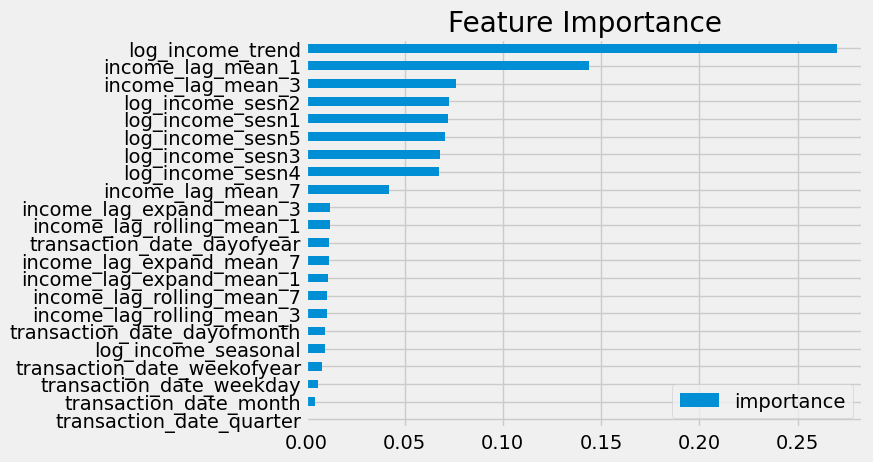

In [131]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [78]:
#based on fi, dropping quarter and weekofyear

In [132]:
#chnaging values back to normal for visualization
test_out_df['log_income2'] = np.expm1(test_out_df['log_income'])
X_test_out['pred2'] = np.expm1(X_test_out['pred'])

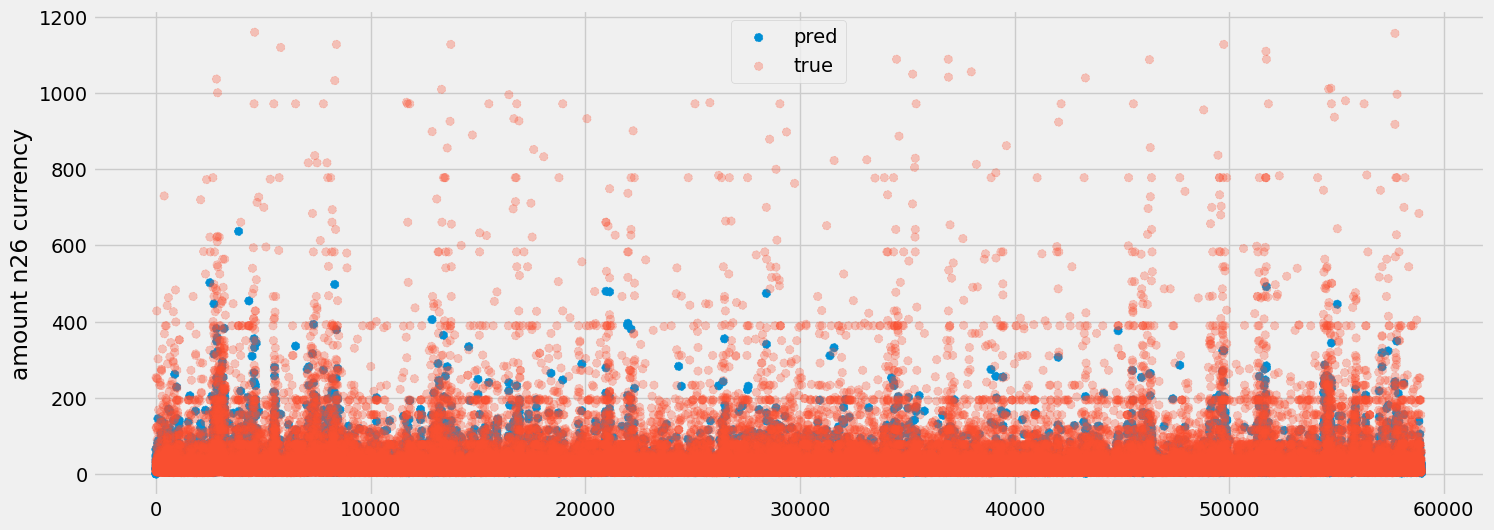

In [134]:
predictions = pd.DataFrame({'y_true': test_out_df['log_income2'], 'y_pred': X_test_out['pred2']})

plt.figure(figsize=(16,6))
plt.scatter(range(predictions.shape[0]), predictions['y_pred'], label='pred', linestyle='dashed',)
plt.scatter(range(predictions.shape[0]), predictions['y_true'], label='true', linestyle='dashed',alpha=0.3)
plt.ylabel('amount n26 currency')
plt.legend();

In [ ]:
#model is not performing so well while predicting higher values

### Training on all the data:

In [138]:
expenses_data = data_transformation(df_out)

In [139]:
# Retrain on all data

X_all = expenses_data[FEATURES]
y_all = expenses_data[TARGET]

model_expenses = xgb.XGBRegressor(booster='gbtree', 
                           n_estimators=600,
                           early_stopping_rounds=50,
                           base_score=0.5,
                           max_depth= 5,
                           learning_rate=0.06,
                           eval_metric='rmsle',
                      )
model_expenses.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmsle:0.85880
[100]	validation_0-rmsle:0.17635
[200]	validation_0-rmsle:0.16546
[300]	validation_0-rmsle:0.16179
[400]	validation_0-rmsle:0.16022
[500]	validation_0-rmsle:0.15934
[599]	validation_0-rmsle:0.15871


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
#Saving model for later using pickle

#with open('expenses_pred_model.pkl', 'wb') as file:
    #pickle.dump(model_expenses, file)

# Load the model from the file
#with open('expenses_pred_model.pkl', 'rb') as file:
    #expenses_model = pickle.load(file)


Both models can be improved further by hypermarater tuning during the cross validation process
Can perform more analysis to see if there are any outliers that can be removed
Can prerform error analysis on datapoints where model is not performing so well to understand the data better
Try other forecasting models such as prophet etc to compare the results with Xgboost